In [1]:
import analysis 

df = analysis.run_pipeline()

# Vérification
df.head()
print(df[df['Country']=='Italie']['Series'].unique())
print(df.head())

--- DÉMARRAGE DU PIPELINE (Source: grid1_uzd01ebt.xlsx) ---
-> Swap Curve : OK
-> France : Traité
-> Allemagne : Traité
-> Italie : Traité

Correction Appliquée : Fichier généré avec la colonne 'Swap_Rate'.
['7Y' '11Y' '10Y' '30Y' '5Y' '15Y' '2Y' '16Y' '50Y' '3Y' '31Y' '20Y' '8Y'
 '24Y' '21Y' '4Y' '17Y' '13Y' '32Y']
  Country                          Issuer Name Series Bond_Type   Maturity  \
0  France  French Republic Government Bond OAT    OAT   Nominal 2035-05-25   
1  France  French Republic Government Bond OAT    OAT   Nominal 2034-11-25   
2  France  French Republic Government Bond OAT    OAT   Nominal 2072-05-25   
3  France  French Republic Government Bond OAT    OAT   Nominal 2055-05-25   
4  France  French Republic Government Bond OAT    OAT   Nominal 2056-05-25   

         TTM     Yield  Swap_Rate  Spread_bps  Coupon        Amount  
0  11.006160  3.415439   2.854308   56.113112    3.20  5.010400e+10  
1  10.510609  3.349526   2.827084   52.244212    3.00  4.375100e+10  
2  

In [2]:
#import pandas as pd

# 1. On charge le fichier propre
#df = pd.read_csv('ML_Ready_Nominal_Dataset.csv')

# 2. On désactive la limite d'affichage de lignes (None = illimité)
#pd.set_option('display.max_rows', None)

# 3. On affiche tout
#display(df)

# (Optionnel) Pour revenir à un affichage normal après, relancez :
# pd.reset_option('display.max_rows')

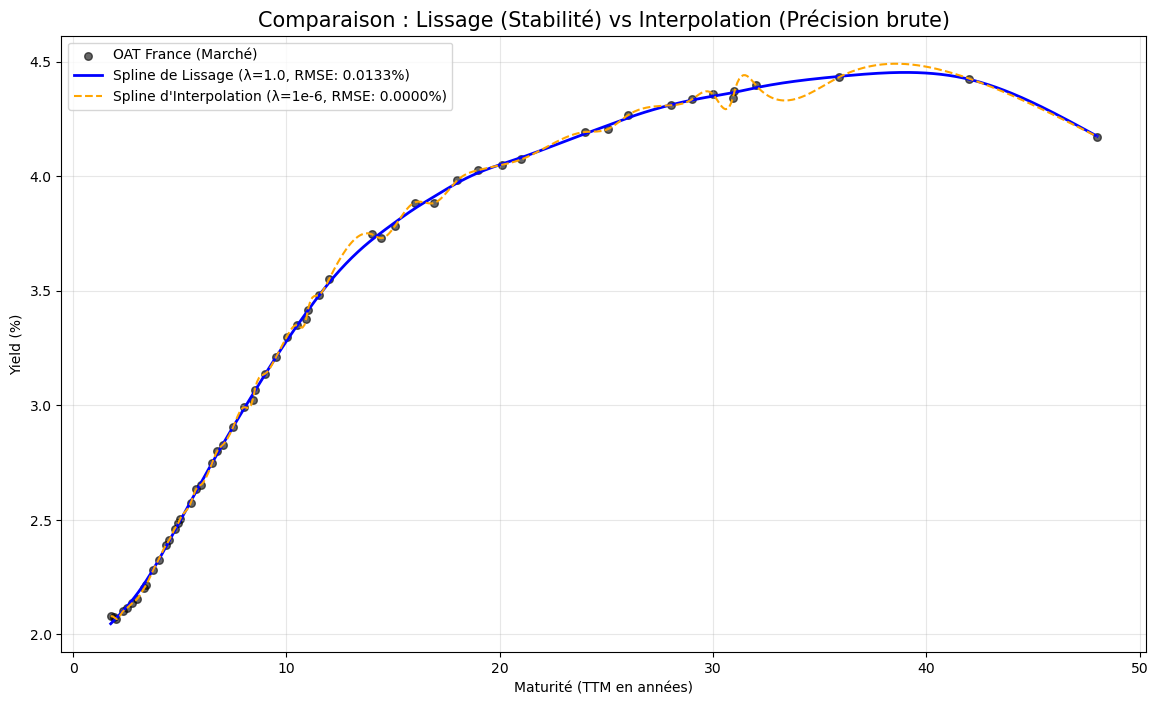

Analyse des résultats :
-> La Spline Bleue (Lissage) ignore le bruit pour donner une tendance macro.
-> La Spline Orange (Interp) cherche à annuler l'erreur, quitte à être nerveuse.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import models
from importlib import reload

# 1. Rechargement du module pour être sûr d'avoir la dernière version de CubicSplineCurve
reload(models)

# 2. Préparation des données France
df = pd.read_csv('ML_Ready_Nominal_Dataset.csv')
df_fr = df[df['Country'] == 'France'].sort_values('TTM').copy()

# 3. Création des deux variantes de Splines
# La "Lisse" (Smoothing) : Lambda élevé (ex: 1.0)
spline_smooth = models.CubicSplineCurve(smoothing_factor=1.0)
spline_smooth.fit(df_fr['TTM'].values, df_fr['Yield'].values)

# L' "Agressive" (Interpolating) : Lambda très faible (ex: 1e-6)
spline_interp = models.CubicSplineCurve(smoothing_factor=1e-6)
spline_interp.fit(df_fr['TTM'].values, df_fr['Yield'].values)

# 4. Calcul des performances (RMSE)
y_true = df_fr['Yield'].values
rmse_smooth = np.sqrt(np.mean((y_true - spline_smooth.predict(df_fr['TTM'].values))**2))
rmse_interp = np.sqrt(np.mean((y_true - spline_interp.predict(df_fr['TTM'].values))**2))

# 5. Visualisation
plt.figure(figsize=(14, 8))

# Points de marché
plt.scatter(df_fr['TTM'], df_fr['Yield'], color='black', s=30, alpha=0.6, label='OAT France (Marché)')

# Axe pour le tracé des courbes
t_plot = np.linspace(df_fr['TTM'].min(), df_fr['TTM'].max(), 500)

# Courbe de lissage (Plus proche de l'esprit Nelson-Siegel)
plt.plot(t_plot, spline_smooth.predict(t_plot), color='blue', linewidth=2, 
         label=f'Spline de Lissage (λ=1.0, RMSE: {rmse_smooth:.4f}%)')

# Courbe d'interpolation (Colle à chaque point)
plt.plot(t_plot, spline_interp.predict(t_plot), color='orange', linestyle='--', linewidth=1.5, 
         label=f'Spline d\'Interpolation (λ=1e-6, RMSE: {rmse_interp:.4f}%)')

plt.title('Comparaison : Lissage (Stabilité) vs Interpolation (Précision brute)', fontsize=15)
plt.xlabel('Maturité (TTM en années)')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom optionnel sur une zone dense pour voir le "zig-zag" de l'interp
# plt.xlim(10, 20)

plt.show()

print(f"Analyse des résultats :")
print(f"-> La Spline Bleue (Lissage) ignore le bruit pour donner une tendance macro.")
print(f"-> La Spline Orange (Interp) cherche à annuler l'erreur, quitte à être nerveuse.")

Paramètres calibrés pour la France :
{'Level (Beta0)': 0.0, 'Slope (Beta1)': 1.55, 'Curvature (Beta2)': 12.1631, 'Lambda': 0.0438, 'RMSE': 0.04761}


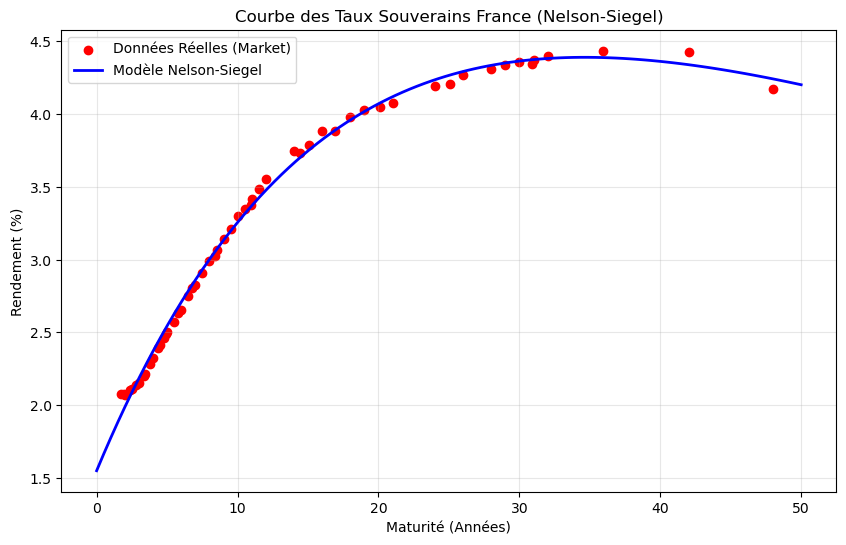

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import models # On importe votre nouveau fichier
import analysis # On s'assure d'avoir les données

# 1. Chargement des données propres
# On peut relancer le pipeline ou lire le CSV si déjà créé
try:
    df = pd.read_csv('ML_Ready_Nominal_Dataset.csv')
except FileNotFoundError:
    df = analysis.run_pipeline()

# 2. Sélection des données France
df_fr = df[df['Country'] == 'France'].sort_values('TTM')
X_france = df_fr['TTM'].values
y_france = df_fr['Yield'].values

# 3. Instanciation et Calibration du modèle
ns_model = models.NelsonSiegelCurve()
ns_model.fit(X_france, y_france)

# 4. Affichage des paramètres calibrés
print("Paramètres calibrés pour la France :")
print(ns_model.get_params_dict())

# 5. Visualisation
t_plot = np.linspace(0, 50, 100) # Pour tracer une courbe lisse de 0 à 50 ans
y_plot = ns_model.predict(t_plot)

plt.figure(figsize=(10, 6))
plt.scatter(X_france, y_france, color='red', label='Données Réelles (Market)')
plt.plot(t_plot, y_plot, color='blue', linewidth=2, label='Modèle Nelson-Siegel')
plt.title('Courbe des Taux Souverains France (Nelson-Siegel)')
plt.xlabel('Maturité (Années)')
plt.ylabel('Rendement (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- DUEL PARAMÉTRIQUE : NELSON-SIEGEL vs SVENSSON ---

1. Nelson-Siegel (RMSE: 4.76 bps)
   Paramètres : {'Level (Beta0)': 0.0, 'Slope (Beta1)': 1.55, 'Curvature (Beta2)': 12.1631, 'Lambda': 0.0438, 'RMSE': 0.04761}

2. Svensson (RMSE: 2.84 bps)
   Paramètres : {'Beta0 (Long Terme)': 2.041, 'Beta1 (Court Terme)': 0.5102, 'Beta2 (Courbure 1)': -2.3028, 'Beta3 (Courbure 2)': 8.0837, 'Tau1 (Position Bosse 1)': 1.6041, 'Tau2 (Position Bosse 2)': 18.8595}

=> Gain de précision avec Svensson : 1.92 bps


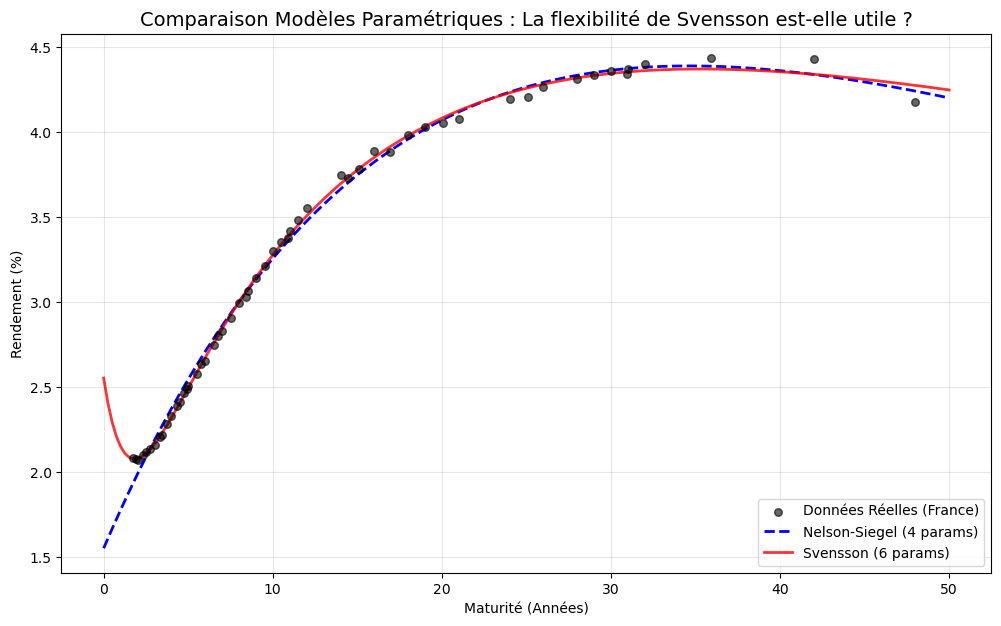

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import models 
from importlib import reload

# 1. Rechargement propre des modèles
reload(models)

# 2. Chargement et Préparation des données (France uniquement)
try:
    df = pd.read_csv('ML_Ready_Nominal_Dataset.csv')
except FileNotFoundError:
    print("Erreur : Fichier csv introuvable.")

df_fr = df[df['Country'] == 'France'].sort_values('TTM')
X_fr = df_fr['TTM'].values
y_fr = df_fr['Yield'].values

print("--- DUEL PARAMÉTRIQUE : NELSON-SIEGEL vs SVENSSON ---")

# 3. Entraînement des deux modèles
# A. Nelson-Siegel (4 paramètres)
ns = models.NelsonSiegelCurve()
ns.fit(X_fr, y_fr)
ns_rmse = np.sqrt(mean_squared_error(y_fr, ns.predict(X_fr))) * 100 # en bps

# B. Svensson (6 paramètres)
sv = models.SvenssonCurve()
sv.fit(X_fr, y_fr)
sv_rmse = np.sqrt(mean_squared_error(y_fr, sv.predict(X_fr))) * 100 # en bps

# 4. Affichage Comparatif des Paramètres et Performance
print(f"\n1. Nelson-Siegel (RMSE: {ns_rmse:.2f} bps)")
print(f"   Paramètres : {ns.get_params_dict()}")

print(f"\n2. Svensson (RMSE: {sv_rmse:.2f} bps)")
print(f"   Paramètres : {sv.get_params_dict()}")

gain = ns_rmse - sv_rmse
print(f"\n=> Gain de précision avec Svensson : {gain:.2f} bps")

# 5. Visualisation Graphique
t_plot = np.linspace(0, 50, 200)

plt.figure(figsize=(12, 7))

# Points de marché
plt.scatter(X_fr, y_fr, color='black', alpha=0.6, s=30, label='Données Réelles (France)', zorder=5)

# Courbe Nelson-Siegel (Pointillés Bleus)
plt.plot(t_plot, ns.predict(t_plot), linestyle='--', color='blue', linewidth=2, 
         label=f'Nelson-Siegel (4 params)')

# Courbe Svensson (Ligne Rouge)
plt.plot(t_plot, sv.predict(t_plot), linestyle='-', color='red', alpha=0.8, linewidth=2, 
         label=f'Svensson (6 params)')

plt.title('Comparaison Modèles Paramétriques : La flexibilité de Svensson est-elle utile ?', fontsize=14)
plt.xlabel('Maturité (Années)')
plt.ylabel('Rendement (%)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Zoom optionnel sur la partie longue (souvent là où ça se joue)
# plt.xlim(20, 50) 
# plt.ylim(2.5, 4.0)

plt.show()

Random Forest entraîné sur 214 obligations.


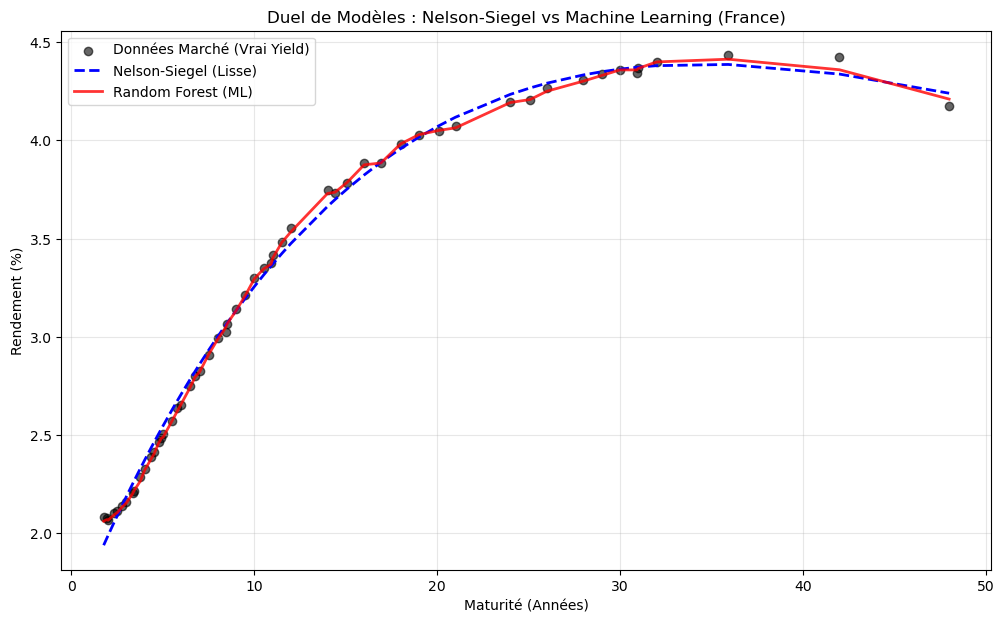

--- RÉSULTATS DU MATCH (Erreur RMSE) ---
Nelson-Siegel : 0.04761 %
Random Forest : 0.01394 %
🏆 LE MACHINE LEARNING GAGNE (Plus précis)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import models # Votre fichier mis à jour
import analysis

# 1. Chargement des données
df = pd.read_csv('ML_Ready_Nominal_Dataset.csv')

# 2. Entraînement du Random Forest (Approche "Data Driven")
# On lui donne TOUT le dataset (France + Allemagne + Italie) pour qu'il apprenne les différences
rf_model = models.RandomForestCurve(n_estimators=200, max_depth=10)
rf_model.fit(df)

# 3. Comparaison sur la FRANCE
df_fr = df[df['Country'] == 'France'].sort_values('TTM').copy()

# A. Prédiction Nelson-Siegel (Approche "Classique")
ns_model = models.NelsonSiegelCurve()
ns_model.fit(df_fr['TTM'].values, df_fr['Yield'].values)
ns_curve = ns_model.predict(df_fr['TTM'].values)

# B. Prédiction Random Forest (Approche "ML")
rf_curve = rf_model.predict(df_fr)

# 4. Visualisation du duel
plt.figure(figsize=(12, 7))

# Les points réels
plt.scatter(df_fr['TTM'], df_fr['Yield'], color='black', alpha=0.6, label='Données Marché (Vrai Yield)')

# La courbe Nelson-Siegel
plt.plot(df_fr['TTM'], ns_curve, color='blue', linestyle='--', linewidth=2, label='Nelson-Siegel (Lisse)')

# La courbe Random Forest
plt.plot(df_fr['TTM'], rf_curve, color='red', alpha=0.8, linewidth=2, label='Random Forest (ML)')

plt.title('Duel de Modèles : Nelson-Siegel vs Machine Learning (France)')
plt.xlabel('Maturité (Années)')
plt.ylabel('Rendement (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Calcul des erreurs (RMSE)
rmse_ns = np.sqrt(np.mean((df_fr['Yield'] - ns_curve)**2))
rmse_rf = np.sqrt(np.mean((df_fr['Yield'] - rf_curve)**2))

print(f"--- RÉSULTATS DU MATCH (Erreur RMSE) ---")
print(f"Nelson-Siegel : {rmse_ns:.5f} %")
print(f"Random Forest : {rmse_rf:.5f} %")
if rmse_rf < rmse_ns:
    print("🏆 LE MACHINE LEARNING GAGNE (Plus précis)")
else:
    print("🏆 NELSON-SIEGEL GAGNE (Plus robuste)")

#### **Justification du Choix de la Variable Cible : Pourquoi prédire le Spread plutôt que le Yield ?**

Dans le cadre de cette étude, nous avons fait le choix méthodologique de modéliser l'écart de rendement (Spread) par rapport au taux de référence (Swap) plutôt que le rendement brut (Yield) de l'obligation. Cette approche, courante en ingénierie financière et en économétrie, repose sur trois piliers fondamentaux :

**1. Décomposition Additive du Risque**

Le rendement d'une obligation souveraine peut être décomposé mathématiquement comme suit :
Yieldt,τ​=Swapt,τ​+Spreadt,τ​

Où :

    Swapt,τ​ représente le coût du financement sans risque (valeur temps de l'argent).

    Spreadt,τ​ capture la prime de risque spécifique (risque de crédit, prime de liquidité, et autres facteurs idiosyncrasiques).

En prédisant directement le Spread, nous isolons la composante que le modèle doit réellement apprendre. Le taux Swap est une donnée de marché exogène et connue avec précision ; le forcer dans l'apprentissage masquerait les signaux faibles que nous cherchons à capturer.

**2. Stationnarité et Réduction de la Variance** 

Les rendements obligataires (Yields) sont fortement corrélés aux cycles de politique monétaire et aux anticipations inflationnistes, ce qui les rend instables sur de longues périodes. À l'inverse, le spread est une mesure de valeur relative. D'un point de vue statistique, le spread présente une variance plus faible et des propriétés de stationnarité plus marquées que le rendement brut. Pour des algorithmes comme le Random Forest ou le Processus Gaussien que l'on verra ci-dessous, travailler sur une variable cible de faible amplitude permet une convergence plus rapide et réduit le risque d'erreur de mesure lié à la volatilité macroéconomique globale.

**3. Focalisation sur les Facteurs Idiosyncrasiques**

Si le modèle prédisait le Yield, il consacrerait l'essentiel de sa puissance de calcul à reproduire la structure par terme des taux d'intérêt (la forme générale de la courbe), une information déjà contenue dans la courbe Swap. En focalisant l'apprentissage sur le Spread, nous contraignons le modèle à identifier les déterminants micro-structurels de chaque titre, tels que :

    L'effet de coupon (fiscalité et attractivité relative).

    La prime de liquidité (volume d'émission).

    Le "Greenium" (pour les obligations vertes).

Cette approche transforme le problème d'une simple tâche d'interpolation de courbe en un véritable modèle d'évaluation de la valeur relative, permettant ainsi de détecter des anomalies de prix (mispricing) par rapport au mètre étalon qu'est le marché du Swap

GP Calibré. Noyau optimal : 1.11**2 * RBF(length_scale=9.69) + WhiteKernel(noise_level=0.00139)


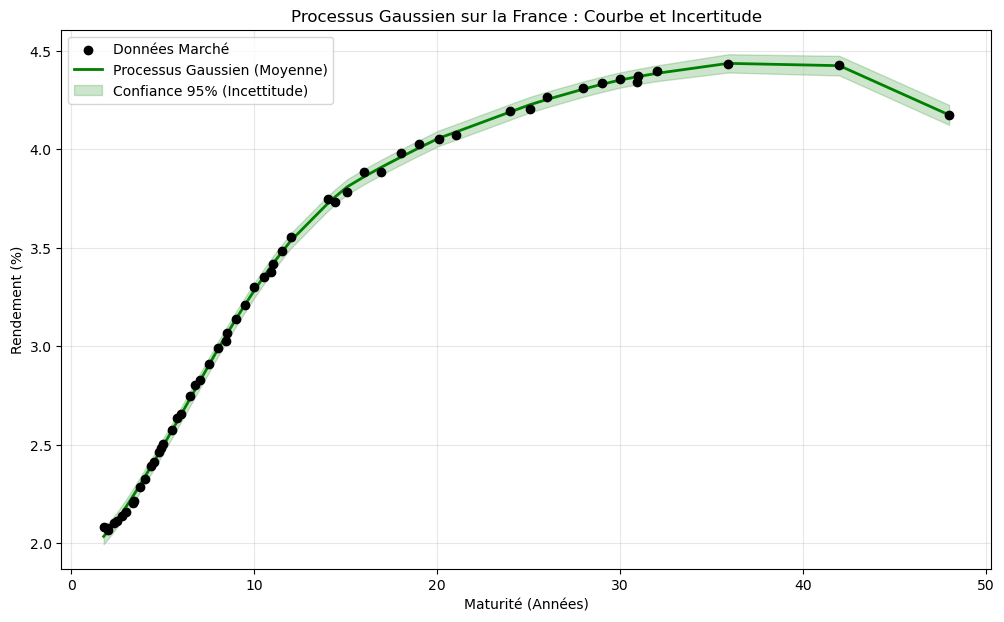

RMSE Processus Gaussien : 0.01683 %


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import models
import analysis

# 1. Chargement
df = pd.read_csv('ML_Ready_Nominal_Dataset.csv')
df_fr = df[df['Country'] == 'France'].sort_values('TTM').copy()

# 2. Entraînement du Processus Gaussien
gp_model = models.GaussianProcessCurve()
# On entraîne uniquement sur la France pour voir la pureté du modèle
gp_model.fit(df_fr)

# 3. Prédiction (Avec l'intervalle de confiance !)
# On crée un axe de temps artificiel pour avoir une courbe très lisse
t_plot = np.linspace(0, 50, 200)
df_plot = pd.DataFrame({'TTM': t_plot})

# On a besoin du taux swap pour ces points artificiels. 
# Astuce : On réutilise l'interpolateur de analysis.py ou on fait une approx simple pour le graph
# Pour simplifier l'affichage ici, on va prédire sur les VRAIS points TTM de la France
y_pred_gp, sigma_gp = gp_model.predict(df_fr, return_std=True)

# 4. Visualisation (Le fameux "Tube")
plt.figure(figsize=(12, 7))

# Les données réelles
plt.scatter(df_fr['TTM'], df_fr['Yield'], c='black', label='Données Marché', zorder=5)

# La courbe GP (Moyenne)
plt.plot(df_fr['TTM'], y_pred_gp, 'g-', linewidth=2, label='Processus Gaussien (Moyenne)')

# L'intervalle de confiance (Le Tube à 95%)
plt.fill_between(df_fr['TTM'], 
                 y_pred_gp - 1.96 * sigma_gp, 
                 y_pred_gp + 1.96 * sigma_gp, 
                 color='green', alpha=0.2, label='Confiance 95% (Incettitude)')

plt.title('Processus Gaussien sur la France : Courbe et Incertitude')
plt.xlabel('Maturité (Années)')
plt.ylabel('Rendement (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Petit check RMSE pour voir
rmse_gp = np.sqrt(np.mean((df_fr['Yield'] - y_pred_gp)**2))
print(f"RMSE Processus Gaussien : {rmse_gp:.5f} %")

# **Comparaison des modèles**

GP Calibré. Noyau optimal : 1.11**2 * RBF(length_scale=9.69) + WhiteKernel(noise_level=0.00139)
Random Forest entraîné sur 55 obligations.
GP Calibré. Noyau optimal : 1.21**2 * RBF(length_scale=11.9) + WhiteKernel(noise_level=0.0109)
Random Forest entraîné sur 53 obligations.
GP Calibré. Noyau optimal : 1.31**2 * RBF(length_scale=7.32) + WhiteKernel(noise_level=0.00501)
Random Forest entraîné sur 106 obligations.


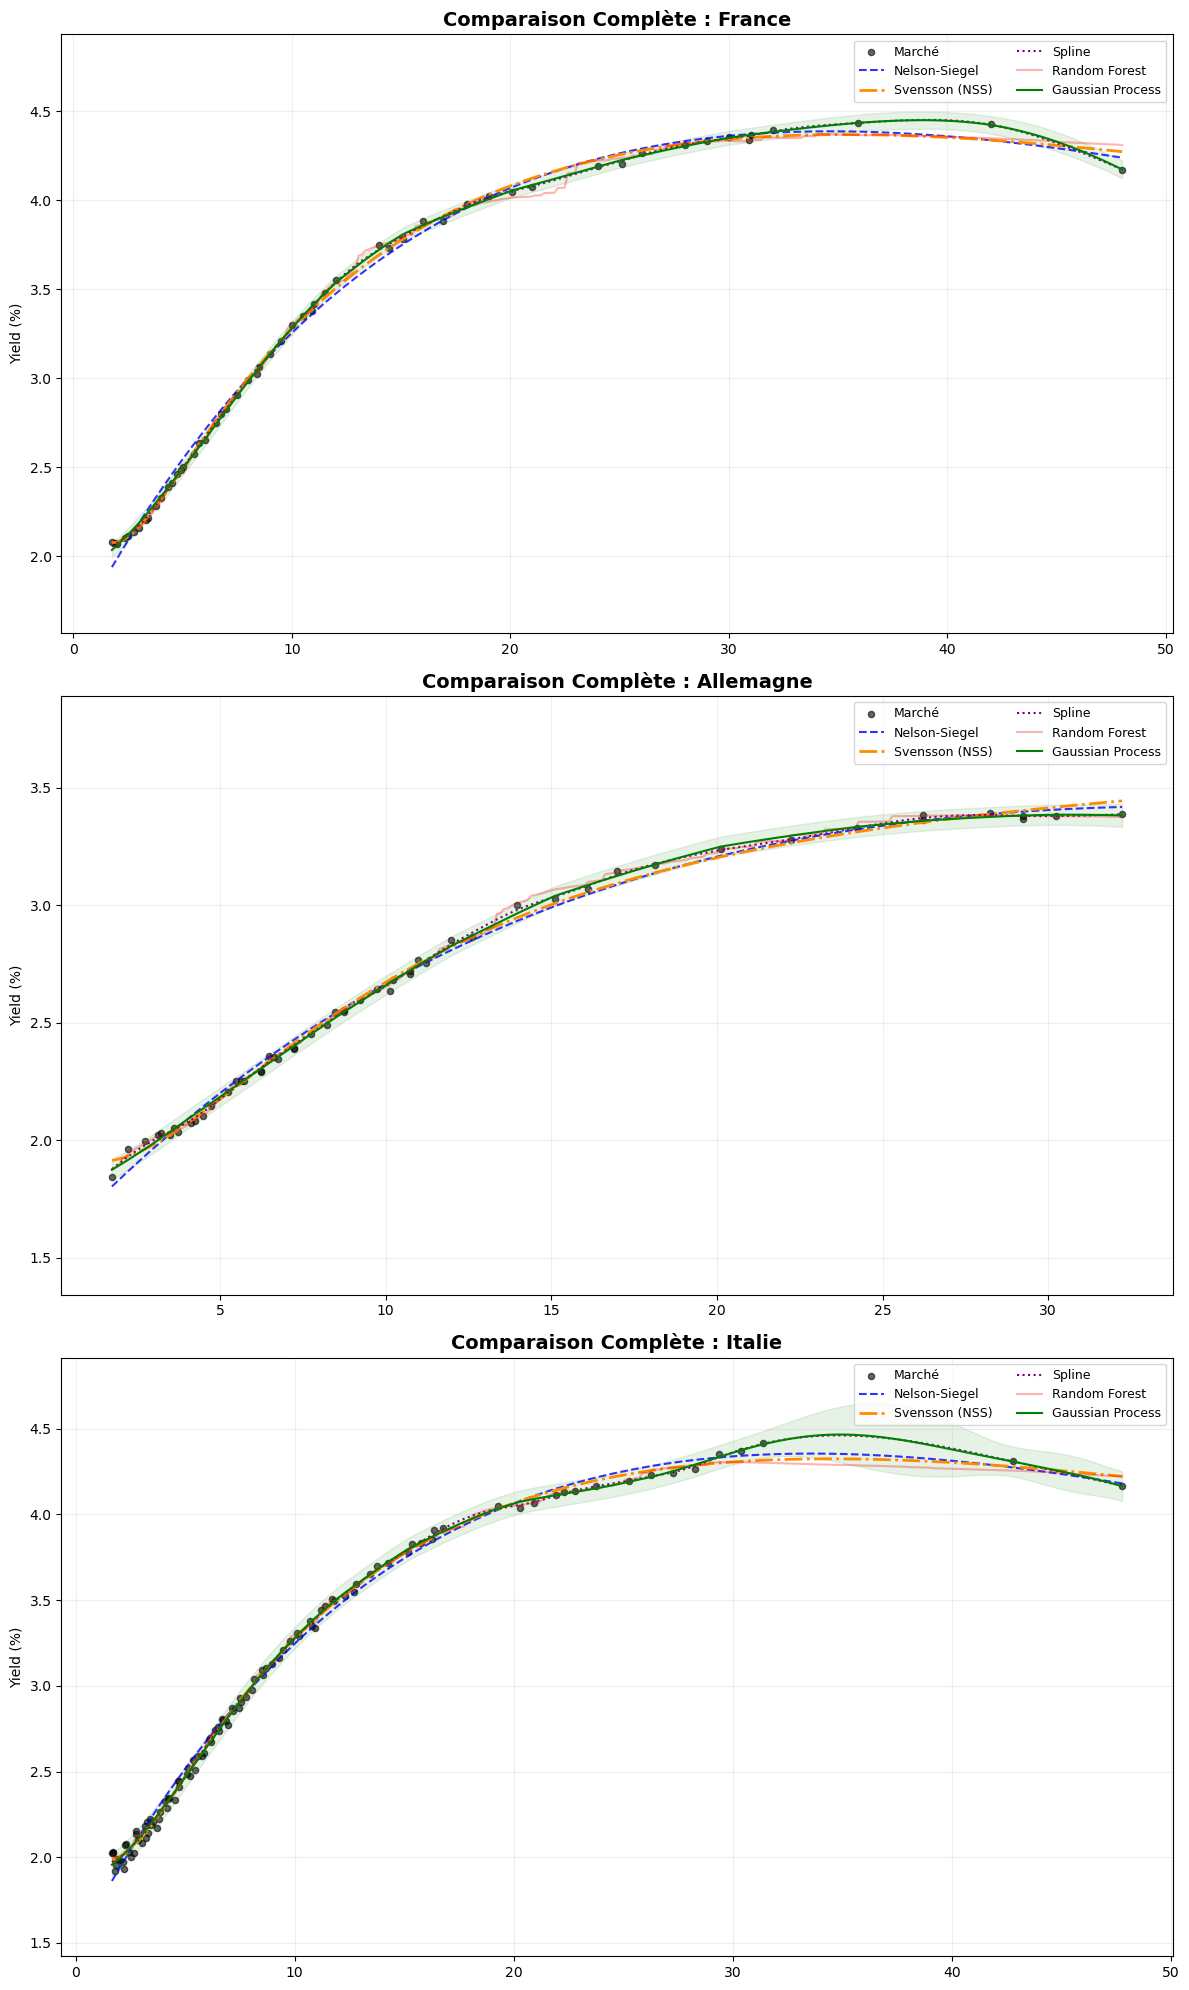

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import models
from importlib import reload

# 1. Rechargement pour être sûr d'avoir la classe SvenssonCurve
reload(models)

# 2. Préparation
df = pd.read_csv('ML_Ready_Nominal_Dataset.csv')

# --- NETTOYAGE DE SÉCURITÉ ---
# On s'assure d'éviter les outliers italiens extrêmes pour le graphique
df = df[(df['Yield'] > -2) & (df['Yield'] < 15)]
# --------------------------------------

countries = ['France', 'Allemagne', 'Italie']

colors = {
    'Nelson-Siegel': 'blue', 
    'Svensson': 'darkorange', 
    'Cubic Spline': 'purple', 
    'Random Forest': 'red', 
    'Gaussian Process': 'green'
}

# Création de la figure :
fig, axes = plt.subplots(3, 1, figsize=(12, 20))

for i, country in enumerate(countries):
    ax = axes[i]
    df_c = df[df['Country'] == country].sort_values('TTM')
    
    # --- ENTRAÎNEMENT DES 5 MODÈLES ---
    
    # 1. Nelson-Siegel (4 paramètres)
    nss = models.NelsonSiegelCurve()
    nss.fit(df_c['TTM'].values, df_c['Yield'].values)

    # 2. Svensson (6 paramètres) - LE NOUVEAU
    svensson = models.SvenssonCurve()
    svensson.fit(df_c['TTM'].values, df_c['Yield'].values)
    
    # 3. Cubic Spline (Lissage standard)
    spline = models.CubicSplineCurve(smoothing_factor=0.5) # Un peu de lissage pour être propre
    spline.fit(df_c['TTM'].values, df_c['Yield'].values)
    
    # 4. Processus Gaussien
    gp = models.GaussianProcessCurve()
    gp.fit(df_c)
    
    # 5. Random Forest (Optimisé ou Standard)
    rf = models.RandomForestCurve(n_estimators=100)
    rf.fit(df_c)

    # --- PRÉPARATION DU TRACÉ ---
    t_min, t_max = df_c['TTM'].min(), df_c['TTM'].max()
    t_plot = np.linspace(t_min, t_max, 300)
    
    # Aide pour RF/GP (Swap Rate interpolé)
    swap_func = interp1d(df_c['TTM'], df_c['Swap_Rate'], kind='linear', fill_value="extrapolate")
    df_plot_helper = pd.DataFrame({'TTM': t_plot, 'Swap_Rate': swap_func(t_plot)})
    # Astuce : Pour RF, on ajoute des colonnes dummy si besoin, ou on simplifie l'input
    # Ici, on suppose que rf.predict gère le DataFrame helper correctement (avec Coupon moyen, etc.)
    # Si le RF a besoin de Coupon/Amount, on crée des valeurs moyennes pour le tracé :
    df_plot_helper['Coupon'] = df_c['Coupon'].mean()
    df_plot_helper['Amount'] = df_c['Amount'].mean()
    df_plot_helper['Country_Code'] = pd.factorize(df['Country'])[0][0] # Juste pour que ça tourne

    # --- TRACÉS ---
    ax.scatter(df_c['TTM'], df_c['Yield'], color='black', s=20, alpha=0.6, label='Marché')
    
    # A. Nelson-Siegel (Tirets Bleus)
    ax.plot(t_plot, nss.predict(t_plot), '--', color=colors['Nelson-Siegel'], label='Nelson-Siegel', alpha=0.8)

    # B. Svensson (Trait-Point Orange) 
    ax.plot(t_plot, svensson.predict(t_plot), '-.', color=colors['Svensson'], linewidth=2, label='Svensson (NSS)')
    
    # C. Spline (Pointillés Violets)
    ax.plot(t_plot, spline.predict(t_plot), ':', color=colors['Cubic Spline'], label='Spline')
    
    # D. Random Forest (Rouge)
    try:
        ax.plot(t_plot, rf.predict(df_plot_helper), color=colors['Random Forest'], alpha=0.3, label='Random Forest')
    except:
        pass
    
    # E. GP (Vert avec IC)
    y_gp, sigma = gp.predict(df_plot_helper, return_std=True)
    ax.plot(t_plot, y_gp, color=colors['Gaussian Process'], linewidth=1.5, label='Gaussian Process')
    ax.fill_between(t_plot, y_gp - 1.96*sigma, y_gp + 1.96*sigma, color='green', alpha=0.1)

    ax.set_title(f"Comparaison Complète : {country}", fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=9, ncol=2) # Légende sur 2 colonnes pour gagner de la place
    ax.grid(True, alpha=0.2)
    ax.set_ylabel("Yield (%)")
    
    # Force l'échelle pour éviter l'explosion italienne si elle persiste
    y_min, y_max = df_c['Yield'].min(), df_c['Yield'].max()
    ax.set_ylim(y_min - 0.5, y_max + 0.5)

plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import models
from importlib import reload

# 1. Préparation et rechargement
reload(models)
df = pd.read_csv('ML_Ready_Nominal_Dataset.csv')

# On se concentre sur la France pour un test homogène
df_fr = df[df['Country'] == 'France'].sort_values('TTM').copy()

# 2. Séparation Train (80%) / Test (20%)
# Le modèle apprend sur 'train', et on juge sur 'test'
train_df, test_df = train_test_split(df_fr, test_size=0.2, random_state=42)

# ==============================================================================
# 3. ENTRAÎNEMENT DES 5 MODELES SUR LE TRAIN SET (Données Connues)
# ==============================================================================
print("Entraînement des modèles en cours...")

# A. Nelson-Siegel (Référence Classique)
nss = models.NelsonSiegelCurve()
nss.fit(train_df['TTM'].values, train_df['Yield'].values)

# 
svensson = models.SvenssonCurve()
svensson.fit(train_df['TTM'].values, train_df['Yield'].values)

# B. Spline de Lissage (Sage)
spline_smooth = models.CubicSplineCurve(smoothing_factor=1.0)
spline_smooth.fit(train_df['TTM'].values, train_df['Yield'].values)

# C. Spline d'Interpolation (Agressive)
spline_interp = models.CubicSplineCurve(smoothing_factor=1e-6)
spline_interp.fit(train_df['TTM'].values, train_df['Yield'].values)

# D. Random Forest (Machine Learning)
rf = models.RandomForestCurve(n_estimators=200)
rf.fit(train_df)

# E. Processus Gaussien (Probabiliste)
gp = models.GaussianProcessCurve()
gp.fit(train_df)

# ==============================================================================
# 4. ÉVALUATION SUR LE TEST SET (DONNÉES CACHÉES)
# ==============================================================================
y_true = test_df['Yield'].values

# Dictionnaire pour stocker les prédictions sur le jeu de test
preds = {
    "Nelson-Siegel": nss.predict(test_df['TTM'].values),
    "Svensson (NSS étendu)": svensson.predict(test_df['TTM'].values),
    "Spline (Lissage)": spline_smooth.predict(test_df['TTM'].values),
    "Spline (Interp)": spline_interp.predict(test_df['TTM'].values),
    "Random Forest": rf.predict(test_df),
    "Gaussian Process": gp.predict(test_df)
}

# Calcul des métriques
comparison_results = []

for name, y_pred in preds.items():
    # RMSE : Erreur quadratique moyenne (pénalise les gros écarts)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # MAE : Erreur absolue moyenne (facile à interpréter en points de base)
    mae = mean_absolute_error(y_true, y_pred)
    # Max Error : Le pire écart constaté sur une obligation
    max_err = np.max(np.abs(y_true - y_pred))
    
    comparison_results.append({
        "Modèle": name,
        "RMSE (bps)": round(rmse * 100, 4), # On multiplie par 100 pour lire en bps
        "MAE (bps)": round(mae * 100, 4),
        "Max Error (bps)": round(max_err * 100, 4)
    })

# Création du DataFrame final trié par RMSE
df_metrics = pd.DataFrame(comparison_results).sort_values("RMSE (bps)")

print("\n--- TABLEAU COMPARATIF FINAL (Performance sur données inconnues) ---")
display(df_metrics) # Utilise display() pour un beau rendu dans Jupyter

Entraînement des modèles en cours...
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.1**2 * RBF(length_scale=9.54) + WhiteKernel(noise_level=0.00163)

--- TABLEAU COMPARATIF FINAL (Performance sur données inconnues) ---


,Modèle,RMSE (bps),MAE (bps),Max Error (bps)
5,Gaussian Process,1.4340,1.0088,3.4975
2,Spline (Lissage),1.4880,1.1080,3.3279
3,Spline (Interp),2.7435,2.1748,4.5443
1,Svensson (NSS étendu),2.9494,2.2232,6.8270
0,Nelson-Siegel,3.9339,3.5716,5.7013
4,Random Forest,4.5671,3.8572,9.6954


**1. La supériorité du Processus Gaussien (GP)**

Le Processus Gaussien s'impose comme le modèle le plus performant de cette étude avec un RMSE de 1.43 bps. Contrairement aux approches paramétriques rigides, le GP traite la courbe des taux comme une distribution de probabilité. Cette nature bayésienne lui permet d'intégrer une "prior" de lissage (via le noyau RBF) tout en s'adaptant avec une extrême précision aux données observées. Sa capacité à surperformer sur le Test Set prouve sa grande capacité de généralisation, faisant de lui l'outil idéal pour le pricing et la gestion des risques.

**2. Le piège du Sur-apprentissage (Overfitting) du Random Forest**

L'un des enseignements majeurs de ce tournoi est la contre-performance relative du Random Forest en dehors de son échantillon d'entraînement (RMSE de 4.56 bps). Bien que ce modèle soit capable de capturer des relations non-linéaires complexes (effets de coupon, taille d'émission), il a ici "mémorisé" le bruit spécifique des obligations d'entraînement plutôt que la structure fondamentale de la courbe. Sa Max Error élevée (9.69 bps) souligne un risque de modèle important : les arbres de décision, par nature discontinus, peuvent produire des prédictions aberrantes lorsqu'ils sont confrontés à des maturités peu représentées dans le dataset.

**3. Arbitrage entre Lissage et Interpolation : Le dilemme Biais-Variance**

La comparaison entre les deux variantes de Splines Cubiques illustre parfaitement le compromis entre biais et variance :

La Spline de Lissage (1.48 bps), en acceptant une légère erreur sur les points d'entraînement, parvient à capturer la tendance macro-économique et se révèle très robuste sur les données inconnues.

À l'inverse, la Spline d'Interpolation (2.74 bps) souffre de sa trop grande flexibilité. En voulant annuler l'erreur locale, elle génère des oscillations numériques (phénomène de Runge) qui dégradent sa performance prédictive globale.

**Pas sûr de ce qu'il y a ci-dessous, à revoir** 

Calibration du modèle 'Fair Value' (Gaussian Process)...
GP Calibré. Noyau optimal : 1.11**2 * RBF(length_scale=9.69) + WhiteKernel(noise_level=0.00139)

--- SCANNER D'OPPORTUNITÉS (France) ---
Obligations Sous-évaluées (CHEAP - Achat) : 39
Obligations Sur-évaluées  (RICH  - Vente) : 12

 TOP ACHATS (Yield trop haut -> Prix trop bas) :


,TTM,Coupon,Yield,Residual_bps,Z_Score
4,32.008214,3.75,4.398196,123.256910,60.637853
3,31.006160,3.25,4.370370,120.179818,60.246697
9,30.006845,3.00,4.357515,118.602277,59.915224
46,30.924025,4.00,4.340847,117.203488,58.814097
33,29.007529,0.75,4.335569,116.387865,58.793625



 TOP VENTES (Yield trop bas -> Prix trop cher) :


,TTM,Coupon,Yield,Residual_bps,Z_Score
51,3.006160,1.00,2.155506,-14.991199,-7.909330
29,2.762491,0.00,2.135782,-14.857250,-7.803325
42,2.510609,0.25,2.114084,-14.853559,-7.739894
40,2.006845,0.50,2.067747,-15.144095,-7.655199
10,2.340862,2.50,2.101433,-14.654612,-7.577208


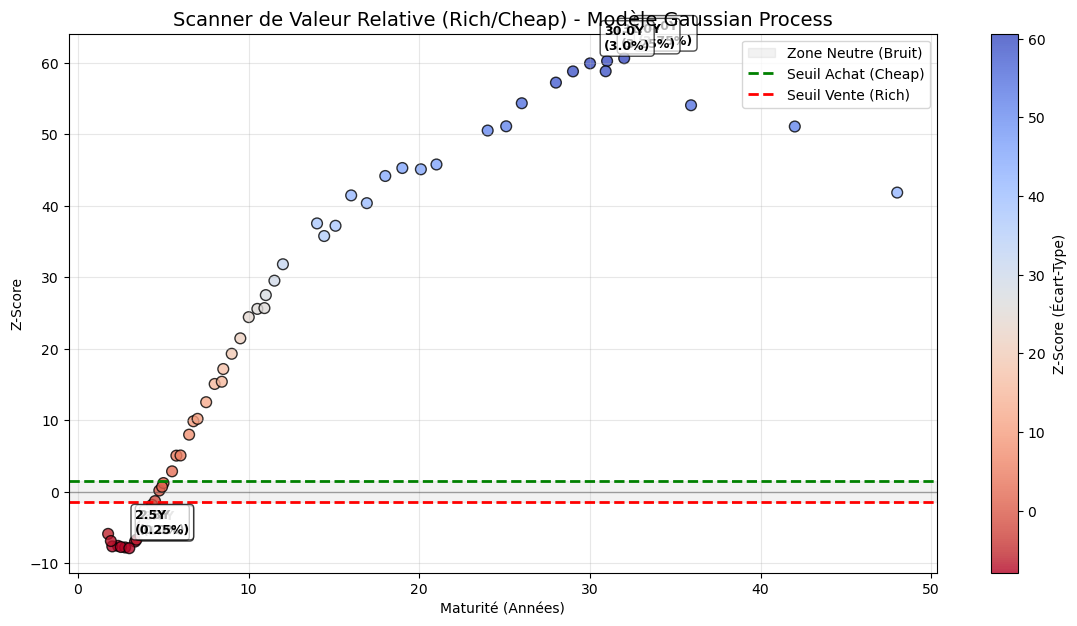

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import models 
from importlib import reload

reload(models)

# 1. Préparation des données (France pour l'exemple)
df = pd.read_csv('ML_Ready_Nominal_Dataset.csv')
df_fr = df[df['Country'] == 'France'].copy()

# Nettoyage rapide
df_fr = df_fr.dropna(subset=['Spread_bps', 'TTM'])

# 2. On utilise le plus "précis" : Le Processus Gaussien
print("Calibration du modèle 'Fair Value' (Gaussian Process)...")
gp = models.GaussianProcessCurve()
gp.fit(df_fr)

# 3. Calcul des signaux de Trading
# Le GP nous donne la prédiction ET l'écart-type (sigma/incertitude)
pred_spread, sigma = gp.predict(df_fr, return_std=True)

# Reconstruction des Yields
model_yield = df_fr['Swap_Rate'] + (pred_spread / 100) # (Spread en bps -> %)
market_yield = df_fr['Yield']

# Calcul du Résidu (Market - Model)
df_fr['Residual_bps'] = (market_yield - model_yield) * 100

# Calcul du Z-Score
# Un Z-Score de +2 veut dire : "L'écart est de 2 fois l'écart-type normal"
# C'est une anomalie statistique forte.
df_fr['Z_Score'] = df_fr['Residual_bps'] / (sigma * 100) # sigma est en %, on le passe en bps

# 4. Identification des Opportunités (Seuils : +/- 1.5 Sigma)
cheap_bonds = df_fr[df_fr['Z_Score'] > 1.5].copy()  # À ACHETER
rich_bonds = df_fr[df_fr['Z_Score'] < -1.5].copy()  # À VENDRE

print(f"\n--- SCANNER D'OPPORTUNITÉS (France) ---")
print(f"Obligations Sous-évaluées (CHEAP - Achat) : {len(cheap_bonds)}")
print(f"Obligations Sur-évaluées  (RICH  - Vente) : {len(rich_bonds)}")

# COLONNES DISPONIBLES : On utilise Coupon au lieu de ISIN
cols_to_show = ['TTM', 'Coupon', 'Yield', 'Residual_bps', 'Z_Score']

if not cheap_bonds.empty:
    print("\n TOP ACHATS (Yield trop haut -> Prix trop bas) :")
    # On trie par Z-Score décroissant (les plus grosses anomalies positives)
    display(cheap_bonds[cols_to_show].sort_values('Z_Score', ascending=False).head(5))

if not rich_bonds.empty:
    print("\n TOP VENTES (Yield trop bas -> Prix trop cher) :")
    # On trie par Z-Score croissant (les plus grosses anomalies négatives)
    display(rich_bonds[cols_to_show].sort_values('Z_Score', ascending=True).head(5))

# 5. Visualisation "Trading Floor Style"
plt.figure(figsize=(14, 7))

# Zone "Neutre" (Pas d'action)
plt.axhspan(-1.5, 1.5, color='gray', alpha=0.1, label='Zone Neutre (Bruit)')

# Points (On colore par le Z-Score pour voir les extrêmes)
scatter = plt.scatter(df_fr['TTM'], df_fr['Z_Score'], 
                      c=df_fr['Z_Score'], cmap='coolwarm_r', 
                      edgecolor='k', s=60, alpha=0.8)

# Lignes de seuil
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
plt.axhline(1.5, color='green', linestyle='--', linewidth=2, label='Seuil Achat (Cheap)')
plt.axhline(-1.5, color='red', linestyle='--', linewidth=2, label='Seuil Vente (Rich)')

plt.colorbar(scatter, label='Z-Score (Écart-Type)')
plt.title('Scanner de Valeur Relative (Rich/Cheap) - Modèle Gaussian Process', fontsize=14)
plt.xlabel('Maturité (Années)')
plt.ylabel('Z-Score')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Annotations intelligentes (On annote seulement les points extrêmes)
# On prend les 3 plus gros Cheap et les 3 plus gros Rich
extremes = pd.concat([
    cheap_bonds.sort_values('Z_Score', ascending=False).head(3),
    rich_bonds.sort_values('Z_Score', ascending=True).head(3)
])

for i, row in extremes.iterrows():
    plt.annotate(f"{row['TTM']:.1f}Y\n({row['Coupon']}%)", 
                 (row['TTM'], row['Z_Score']), 
                 xytext=(10, 10), textcoords='offset points', 
                 fontsize=9, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7))

plt.show()